# LSTM Model
As per yidi, need to work on deep learning part of the project. Gonna just try a quick shotgun approach to see what could work

Supposedly would be nice to use the entire segment for LSTM, but lets just use 20 second segments for now

In [2]:
import glob 
import os
import pandas as pd
import statsmodels as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from importlib import reload
from sklearn import model_selection, metrics
from tqdm.auto import tqdm
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from src import main, feature_model

labels1 = pd.read_csv('data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv')
labels2 = pd.read_csv('data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv')

In [7]:
%%bash
ls ../beat_pd/data/real-pd/clinical_data/

REAL-PD_Demographics.csv
REAL-PD_Smartphone_Metadata.csv
REAL-PD_UPDRS_Part1_2_4.csv
REAL-PD_UPDRS_Part3.csv


In [2]:
labels = labels1.dropna()

In [2]:
#lets go and filter data with some utility funcs
from scipy.signal import butter, lfilter

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

# grabs some filter constants for making bandpass filter
#    order is kinda like strength of filter... higher leads to more ideal filter but has weird interactions near the edges of the filter
#    lower is less ideal but results in less artifacts being generated
#    this is a bit of a cheat anyways, using a lowpass and highpass together, there may be less sketch filter designs applicable
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lp_filter(data, lowcut, fs, order=5):
    nyq = 0.5 * fs #just get the highest freq possible (nyquist, and bandgap it!)
    hc = nyq * 0.9 #can't accept exactly nyq
    print("hc:", hc)
    return butter_bandpass_filter(data, lowcut, hyc, fs, order)
def butter_bandgap_filter(data, lowcut, highcut, fs, order=5):
    if highcut is None:
        return butter_bandgap_filter(data, lowcut, fs, order)
    toRemove = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    return data - toRemove
from src.main import read_seq

def get_data(m_id):
    data = pd.read_csv(f"/home/ms994/beat_pd/data/cis-pd/training_data/{m_id}.csv", index_col="Timestamp", header=0)
    return data.set_index(pd.to_timedelta(data.index, unit="s"))
def get_preprocessed_data(measurement_id, low_f=1, high_f=10):
    data = get_data(measurement_id)
    #50 hz, make a bandpass between 1 and 10 hz, with order of 5
    data = butter_bandpass_filter(data, low_f, high_f, 50, 5)
    return data

In [ ]:
all_data = 

## Let's try just using the frequency data

In [3]:
import pickle as pkl
#from the EDA.ipynb
np_x_data = pkl.load(open("/n/scratch2/ms994/beat_pd_frequency_data.pkl", "rb"))
y = pkl.load(open("/n/scratch2/ms994/beat_pd_labels_1s.pkl", "rb"))

In [5]:
np_x_data.shape, y.shape

((2210912, 3, 26), (2210912, 5))

In [4]:
import tensorflow as tf

### Reshape back out into correct shape
I flattened this between measurements originally as a way to run RF on everything, but running this as a sequence may make much more sense.
The way I concatenated everything has maintained order, so I should be able to separate back out while keeping chronological order.

In [5]:
#grab all the measurement ids
m_ids = y.measurement_id.unique()

In [6]:
m_ids.shape #only 963 in here

(963,)

In [10]:
label = labels1.dropna()

In [11]:
label.shape

(963, 5)

In [7]:
reshapedData = []
for m_id in m_ids:
    reshapedData.append(np_x_data[y.measurement_id==m_id])

In [43]:
reshapedData[0].shape[0]

1799

In [12]:
# lets try for 100 seconds of data with 50 second overlap
time_reshaped_data = []
time_reshaped_y = []
for i, m_id in enumerate(m_ids):
    max_instances = int(np.floor(reshapedData[i].shape[0]/50 - 1) )
    for j in range(max_instances):
        time_reshaped_data.append(reshapedData[i][j*50:j*50 + 100])
        time_reshaped_y.append(label[label.measurement_id == m_id])

In [13]:
time_reshaped_data = np.array(time_reshaped_data)

In [14]:
time_reshaped_data.shape #lets try 1d cnn

(42707, 100, 3, 26)

looks like it is a correct pad value, nothing in the sequence matches

In [35]:
import sys, os
import tensorflow as tf
sys.path.append(os.path.realpath("/home/ms994/dbmi_eeg_clustering")) #lol, i have a ton of utility classes here
from keras_models.metrics import f1, sensitivity, specificity
num_layers = 3
num_lin_layers= 4
inputX = tf.keras.layers.Input((100,3,26))
x = tf.keras.layers.Reshape((100, 3*26))(inputX)
for i in range(num_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(25, (3,))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
x = tf.keras.layers.CuDNNLSTM(20, return_sequences=True)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Flatten()(x)

# on off
for i in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
x = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
y_on_off = tf.keras.layers.ReLU(max_value=4)(x)

model = tf.keras.Model(inputs=[inputX], outputs=[y_on_off])
model.compile("adam", loss="mse")

In [30]:
labels = pd.concat(time_reshaped_y, axis=0)
labels.head()
y = labels.on_off

In [31]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(labels.measurement_id.unique())
# train, valid = train_test_split(labels.measurement_id.unique())

In [32]:
x_train = time_reshaped_data[labels.measurement_id.isin(train)]
y_train = labels[labels.measurement_id.isin(train)]
x_test = time_reshaped_data[labels.measurement_id.isin(test)]
y_test = labels[labels.measurement_id.isin(test)]
# x_valid = time_reshaped_data[labels.measurement_id.isin(valid)]
# y_valid = labels[labels.measurement_id.isin(valid)]

In [84]:
x_train.shape

(32041, 100, 3, 26)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 3, 26)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 100, 78)           0         
_________________________________________________________________
batch_normalization_v1_15 (B (None, 100, 78)           312       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 98, 25)            5875      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 98, 25)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 49, 25)            0         
_________________________________________________________________
batch_normalization_v1_16 (B (None, 49, 25)            100       
__________

In [36]:
history = model.fit(x=x_train, y=y_train.on_off.astype(float).tolist(), validation_split=0.2, epochs=1000, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), tf.keras.callbacks.ModelCheckpoint("beat_pd.h5", save_best_only=True)])

Train on 25718 samples, validate on 6430 samples
Epoch 1/1000
25718/25718 [==============================] - 21s 801us/sample - loss: 2.0566 - val_loss: 1.1809
Epoch 2/1000
25718/25718 [==============================] - 15s 567us/sample - loss: 1.8811 - val_loss: 1.2784
Epoch 3/1000
25718/25718 [==============================] - 15s 570us/sample - loss: 1.8551 - val_loss: 0.9523
Epoch 4/1000
25718/25718 [==============================] - 15s 571us/sample - loss: 1.8163 - val_loss: 1.0835
Epoch 5/1000
25718/25718 [==============================] - 15s 570us/sample - loss: 1.8032 - val_loss: 1.2691
Epoch 6/1000
25718/25718 [==============================] - 15s 569us/sample - loss: 1.7783 - val_loss: 1.6500
Epoch 7/1000
25718/25718 [==============================] - 15s 570us/sample - loss: 1.7621 - val_loss: 1.3872
Epoch 8/1000
25718/25718 [==============================] - 15s 573us/sample - loss: 1.7407 - val_loss: 1.0696


In [37]:
model = tf.keras.models.load_model("beat_pd.h5")

In [38]:
mse = model.evaluate(x_test, y_test.on_off.astype(float).tolist())

10559/10559 [==============================] - 2s 223us/sample - loss: 1.8354


In [39]:
predictions = model.predict(x_test)

In [40]:
y_test.loc[:,"pred"] = predictions

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
intermediate = y_test.groupby("measurement_id").mean()

In [42]:
intermediate.loc[:,"mse"] = (intermediate.on_off - intermediate.pred)**2

In [46]:
intermediate.groupby("subject_id")["on_off"].mean()

subject_id
1004    1.428571
1007    1.041667
1019    1.111111
1023    2.266667
1034    1.250000
1038    0.816327
1043    1.300000
1048    1.692308
1049    1.700000
Name: on_off, dtype: float64

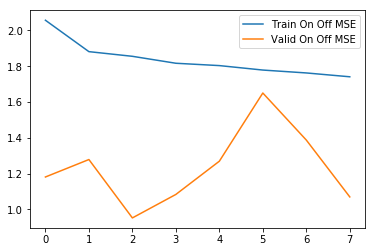

In [44]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train On Off MSE", "Valid On Off MSE"])

# Multioutput Neural Network
Let's try to predict everything at once!

Multiple weights could help regularize the network, but has the issue of trying to find the correct weighting to give each output. There have been a few methods to get around this, the most popular of which is https://arxiv.org/abs/1705.07115

also, i've kinda always wanted to try this model out :P

In [3]:
labels1 = pd.read_csv('data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv')

In [6]:
labels1.groupby("subject_id")["subject_id"].count()

subject_id
1004     82
1006     37
1007    299
1019     45
1020    195
1023    106
1032    177
1034     40
1038    207
1039    130
1043     34
1044     72
1046     67
1048     91
1049     82
1051    194
Name: subject_id, dtype: int64

In [7]:
labels = labels1.dropna()

In [22]:
all_m_id = labels.measurement_id.unique()
all_subject_id = labels.subject_id.unique()

In [24]:
all_m_id.shape, all_subject_id.shape

((963,), (9,))

In [26]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.initializers import Constant
from keras.models import Model
from keras import backend as K
class HomeoschedasticMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, loss_funcs=[],  **kwargs):
        #multiplier is used to change signs
        self.nb_outputs = nb_outputs
        self.output_dim = nb_outputs
        self.is_placeholder = True
        self.multiplier = [1 for i in range(nb_outputs)]
        self.loss_funcs = loss_funcs
        super(HomeoschedasticMultiLossLayer, self).__init__(**kwargs)

    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            initializer=Constant(1)
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=initializer, trainable=True)]
        super(HomeoschedasticMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for i, zipped_args in enumerate(zip(ys_true, ys_pred, self.log_vars)):
            y_true, y_pred, log_var = zipped_args
            # normalized_log_var = log_var[0]/K.sum([other_log_var[0] for other_log_var in self.log_vars])

            precision = K.exp(-log_var[0])
            sign_cost = 1 if self.multiplier[i] > 0 else -1
            if self.multiplier[i] == 0:
                sign_cost = 0
            loss += K.sum(precision * self.multiplier[i] * self.loss_funcs[i](y_true, y_pred)**2. + sign_cost * log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # pass thru the predictions
        return K.concatenate(ys_pred)

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(labels.measurement_id)
train, valid = train_test_split(train)

In [15]:
def get_data(m_id):
    data = pd.read_csv(f"/home/ms994/beat_pd/data/cis-pd/training_data/{m_id}.csv", index_col="Timestamp", header=0)
    return data.set_index(pd.to_timedelta(data.index, unit="s"))

In [ ]:
train_data = []
for m_id in train:
    

In [9]:
import sys, os
import tensorflow as tf
sys.path.append(os.path.realpath("/home/ms994/dbmi_eeg_clustering")) #lol, i have a ton of utility classes here
from keras_models.metrics import f1, sensitivity, specificity
num_layers = 2
num_lin_layers= 4

#shared encoder network
inputX = tf.keras.layers.Input((100,50*20))
x = tf.keras.layers.Reshape((100, 3*26))(inputX)
for i in range(num_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(26*3, (3,))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
x = tf.keras.layers.CuDNNLSTM(50, return_sequences=True)(x)
x = tf.keras.layers.LeakyReLU()(x)
x_base = x  #last layer of the share network




x = x_base
# on off output
for i in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
x = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
y_on_off = tf.keras.layers.ReLU(max_value=4, name="on_off")(x)


# dyskinesia
x = x_base
for i in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
x = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
y_dyskinesia = tf.keras.layers.ReLU(max_value=4, name="dyskinesia")(x)


#tremor
x = x_base
for i in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(200)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
x = tf.keras.layers.Dense(1, kernel_initializer='normal')(x)
y_tremor = tf.keras.layers.ReLU(max_value=4, name="tremor")(x)


#decoder network
x = x_base
for i in range(num_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(26*3, (3,))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(26*3, (3,))(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.UpSampling1D(2)(x)


# the size is off, the original is 100 by 26 by 3, we got 160, 23*3
# x = tf.keras
y_decoder_out = x

model = tf.keras.Model(inputs=[inputX], outputs=[y_on_off, y_dyskinesia, y_tremor, y_decoder_out])
model.compile("adam", loss="mse")

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 1000)    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 78)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 100, 78)      312         reshape[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 98, 78)       18330       batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
leaky_re_l